In [16]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pearson_util 
import descartes
import pygeoj
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import statsmodels.api as sm

# Complete Model

Code for all models

In [17]:
# Load gdf of NUTS 3 regions
gdf_dw = gpd.read_file('C:/Users/seanp/python/NUTS_RG_60M_2016_3035_LEVL_3.geojson')


# Load Transport Demand Prediction (Unit Mio_Vkm)
Mio_Vkm = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_distance_class')
Mio_Vkm = Mio_Vkm.set_index(['country','distance_class'])

# Load Fuel Efficiency for each country and fuel type (Unit kWh/km)
kWh_km = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Vehicle Fuel Efficiency/FE_By_Country_P.xlsm')
kWh_km = kWh_km.set_index(['country','distance_class','Powertrain'])

# Load the transport share of each region compared to it's country
transport_share_region = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/transport_share_region.xlsx', sheet_name = 'regional_transport_share_2050')
transport_share_region = transport_share_region.set_index(['country','id'])

In [18]:
# reindex transport_share_region df with the index of gdf_df and create a multiindex with country code and NUTS 3 code
transport_share_region = transport_share_region.droplevel(0)
transport_share_region = transport_share_region.reindex(gdf_dw.set_index('id').index)
transport_share_region = transport_share_region.set_index(gdf_dw.set_index('CNTR_CODE').index.rename('country'), append=True)

In [19]:
# set id as index
gdf_dw = gdf_dw.set_index('id')

In [20]:
# drop unnecessary regions
gdf_dw = gdf_dw[~gdf_dw.CNTR_CODE.str.startswith('TR')]
gdf_dw = gdf_dw.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200', 'IS002'])

In [21]:
# Adjust units from Mio_Vkm to Vkm
Vkm = Mio_Vkm.multiply(1000000)

In [22]:
# Multiply kWh/km of each powertrain technology by total Vkm to get the kWh of the Vehicle fleet if 100% of vehicles used one powertrain technology
kWh_all_powertrains = Vkm.multiply(kWh_km)

In [23]:
# Load gdf of Roads in Europe and transform the coordinate reference system
roads=gpd.read_file('C:/Users/seanp/Desktop/Roads_Europe')
roads_crs_3035 = roads.to_crs(epsg = 3035)

In [24]:
# create df with road length of NUTS regions in km
road_m = roads_crs_3035.length
road_m = road_m.to_frame(name = 'road_m')
road_m = roads_crs_3035.join(road_m)
roads_nuts = gpd.sjoin(gdf_dw, road_m)
road_nuts_length = roads_nuts.groupby('id').sum()
road_nuts_length_select = road_nuts_length.drop(columns=['COAST_TYPE', 'MOUNT_TYPE', 'LEVL_CODE', 'URBN_TYPE', 'index_right', 'FCsubtype', 'COR', 'EXS', 'LLE', 'LTN', 'MED', 'RST', 'RSU', 'RTT', 'TEN', 'TOL', 'TUC', 'SHAPE_Leng'])
road_km_select = road_nuts_length_select.div(1000)
road_km_select = road_km_select.rename(columns = {'road_m': 'road_km'})

In [25]:
# create df with area of NUTS regions in km^2
gdf_dw['area_km^2'] = gdf_dw.area/1000000
NUTS_Area = gdf_dw.drop(columns=['COAST_TYPE', 'MOUNT_TYPE', 'NAME_LATN', 'CNTR_CODE', 'FID', 'NUTS_ID',
       'NUTS_NAME', 'LEVL_CODE', 'URBN_TYPE', 'geometry'])
gdf_dw = gdf_dw.drop(columns=['area_km^2'])

Code for individual Scenarios

BEV_CEV

In [93]:
# Load results of the Scenarios produced by the VSM
powertrain_share = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results.xlsm', sheet_name = 'BEV_CEV')
powertrain_share = powertrain_share.set_index(['Lifetime','distance_class','Powertrain'])

In [94]:
# delete 'Total' from index in powertrain_share df
pow_share = powertrain_share.drop(index = 'Total', level = 2)

In [95]:
# select average life time of vehicles for this scenario (8y, 10y, 12y, 14y, 16y, 18y, 20y, 22y)
powertrain_share_10y = pow_share.loc['10y']

In [96]:
# multiply kWh if 100% of powertrains were using each technology, by the actual share of powertrains using each technology to get the total kWh demand of the vehicle fleet
kWh_tot = kWh_all_powertrains.multiply(powertrain_share_10y)

In [97]:
# multiply by konstand to transform kWh into gWh
gWh_tot = kWh_tot.multiply(0.000001)

In [98]:
# creats df with total gWh per powertrain technology
gWh_Powertrain_BEV_CEV = gWh_tot.groupby('Powertrain').sum()

In [99]:
# devide the total gWh demand of the vehicle fleet per country up into the NUTS 3 regions of each country
gWh_tot_region = gWh_tot.multiply(transport_share_region)

In [100]:
# Sum up the gWh of each distance class and powertrain technology for each NUTS 3 region
gWh_tot_region_tot = gWh_tot_region.groupby('id').sum()

In [101]:
# join gdf of NUTS 3 regions with gWh per region so it can assign the road_m to the correct NUTS 3 region
gdf_gWh_tot_region_tot = gdf_dw.join(gWh_tot_region_tot)

In [102]:
# devide gWh of each year 2020 - 2050 by road_m to norm the NUTS 3 regions for their size difference
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot.columns = gdf_gWh_tot_region_tot.columns.astype(str)
gWh_div_roadkm_perRegion = gdf_gWh_tot_region_tot[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)

In [103]:
#join gdf of NUTS 3 regions with gWh per road_m
gdf_gWh_div_roadkm_perRegion = gdf_dw.join(gWh_div_roadkm_perRegion)

# Plotting Results

<AxesSubplot:>

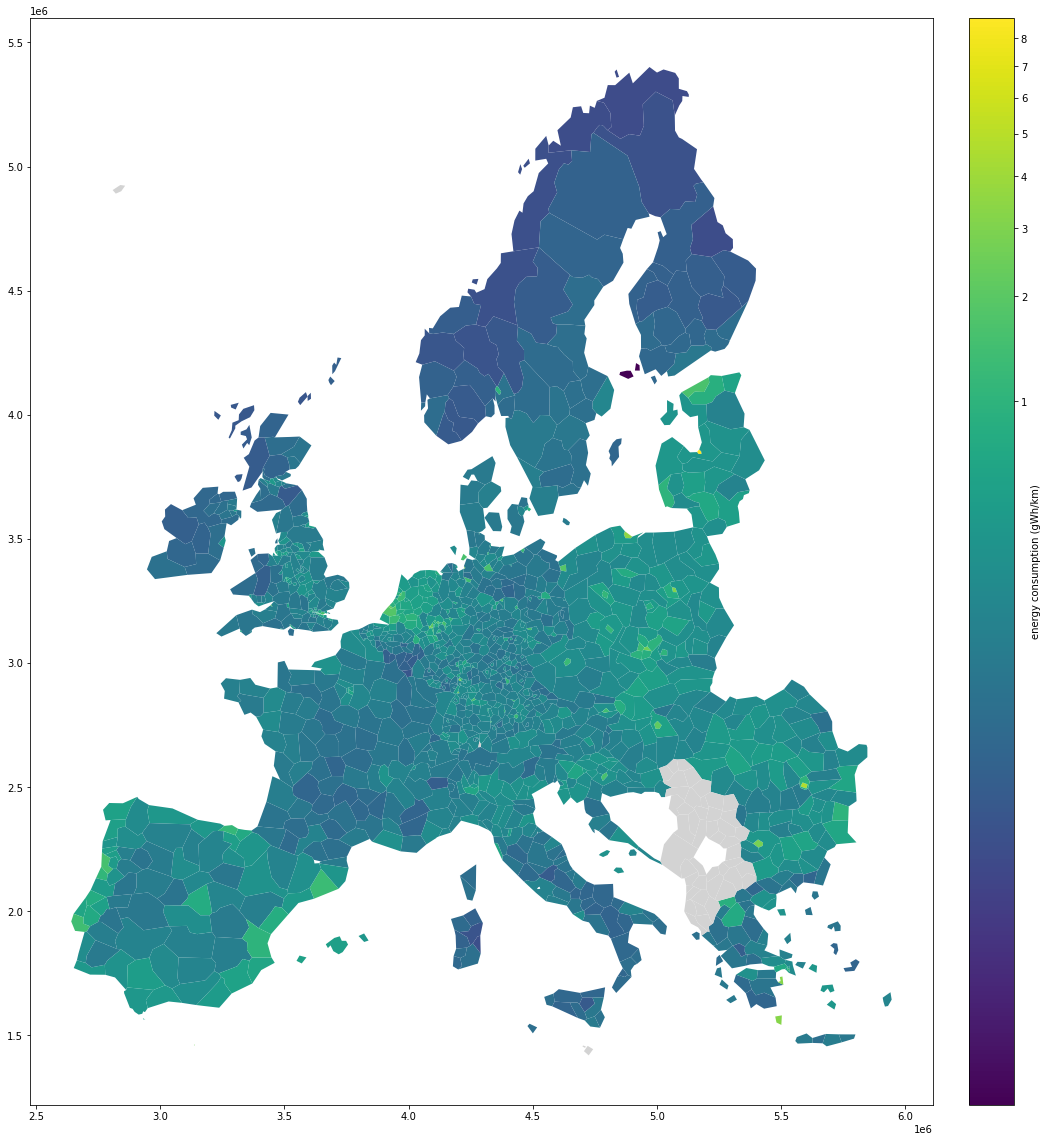

In [58]:
# Plot results
gdf_gWh_div_roadkm_perRegion = gdf_gWh_div_roadkm_perRegion.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_gWh_div_roadkm_perRegion.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

<AxesSubplot:>

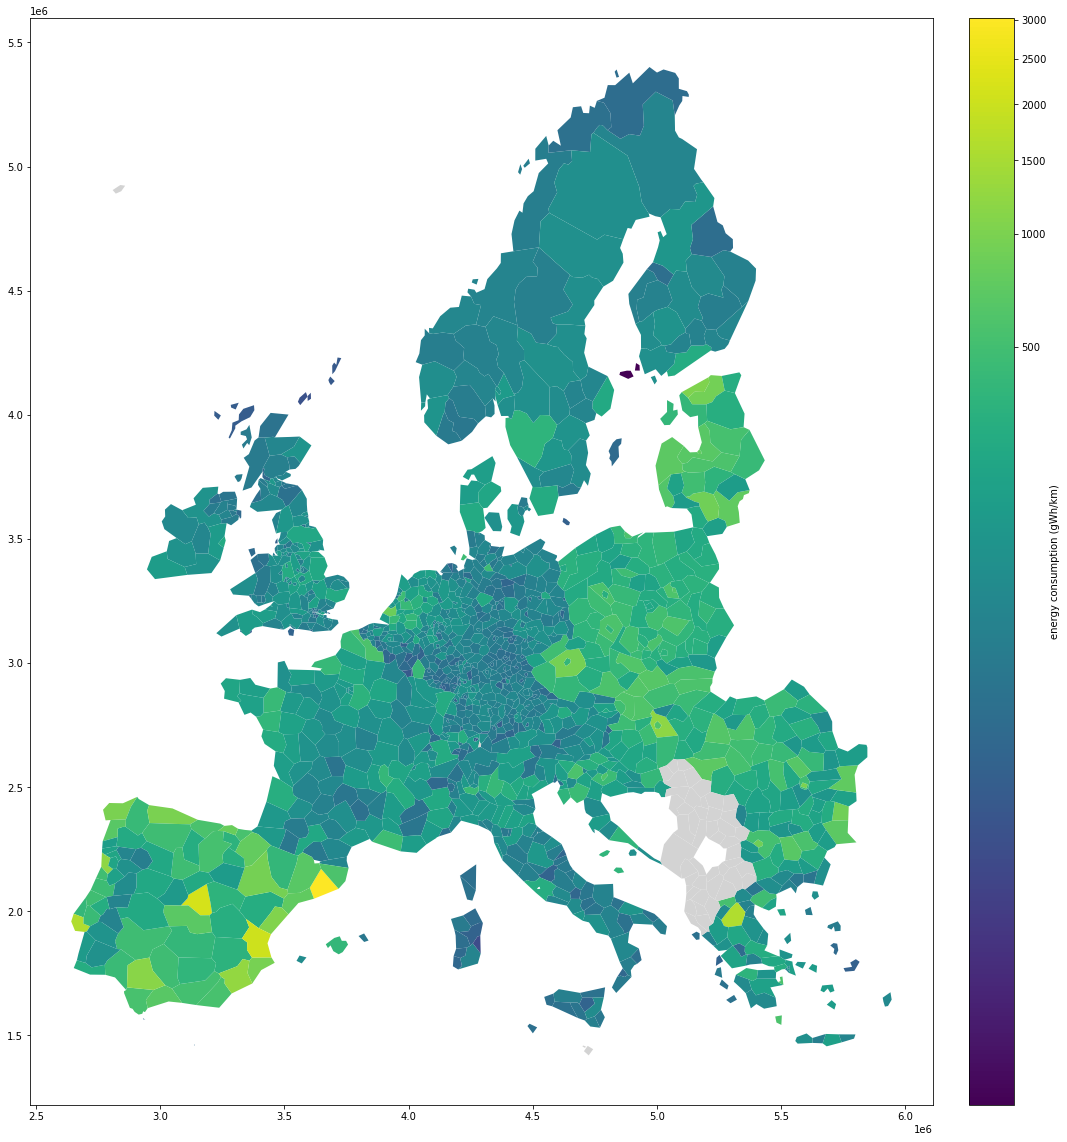

In [59]:
gdf_gWh_tot_region_tot = gdf_gWh_tot_region_tot.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_gWh_tot_region_tot.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

In [39]:
gWh_tot_region_tot.columns = gWh_tot_region_tot.columns.astype(str)

<AxesSubplot:>

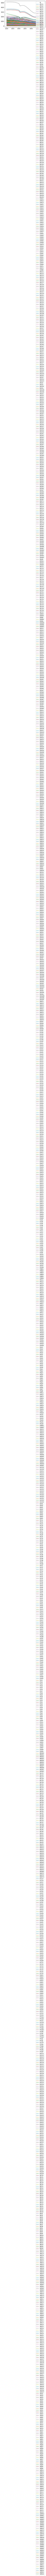

In [40]:
gWh_tot_region_tot = gWh_tot_region_tot[~gWh_tot_region_tot.index.str.startswith('AL')]
gWh_tot_region_tot = gWh_tot_region_tot[~gWh_tot_region_tot.index.str.startswith('TR')]
gWh_tot_region_tot = gWh_tot_region_tot.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200', 'IS002'])
gWh_tot_region_tot.T.plot()

In [41]:
column = gWh_tot_region_tot['2050']
max_value = column.max()
gWh_tot_region_tot.idxmax()

2020    ES511
2021    ES511
2022    ES511
2023    ES511
2024    ES511
2025    ES511
2026    ES511
2027    ES511
2028    ES511
2029    ES511
2030    ES511
2031    ES511
2032    ES511
2033    ES511
2034    ES511
2035    ES511
2036    ES511
2037    ES511
2038    ES511
2039    ES511
2040    ES511
2041    ES511
2042    ES511
2043    ES511
2044    ES511
2045    ES511
2046    ES511
2047    ES511
2048    ES511
2049    ES511
2050    ES511
dtype: object

In [42]:
gWh_Powertrain

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Powertrain,,,,,,,,,,,,,,,,,,,,,
BEV,31.270980,39.046788,49.615477,64.201196,84.664489,113.891334,156.457400,219.788191,352.555622,575.672911,...,85836.917917,93569.782195,98043.929360,100103.763220,101250.405123,102155.489741,103003.468043,103838.299580,104670.118271,105501.245978
Biofuel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Biofuel HEV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CEV,0.012256,0.023558,0.048751,0.107015,0.245730,0.583602,1.421485,3.529225,10.002554,28.327394,...,77850.962188,86973.526021,92611.422976,95331.395093,96900.578617,98163.668475,99354.837609,100529.617782,101700.689761,102870.924145
CNG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CNG HEV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DME,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Diesel,450491.767352,433751.366700,416934.588244,400059.747673,383144.444661,366205.252692,349257.259557,332313.384533,300962.196025,269812.865724,...,1961.383760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Diesel HEV,0.000000,12907.903627,25459.018773,37626.604745,49382.965507,60698.766175,71541.785409,81874.550869,103105.862157,123186.263651,...,50460.083129,23251.956456,7305.802071,1836.276480,427.683460,97.780232,22.279102,5.077503,1.158603,0.264801


In [43]:
gWh_div_roadkm_perRegion

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
id,,,,,,,,,,,,,,,,,,,,,
AL011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKN12,0.106789,0.104443,0.102038,0.099575,0.097052,0.094469,0.091824,0.089114,0.085590,0.081918,...,0.038183,0.035901,0.034701,0.034300,0.034198,0.034174,0.034169,0.034168,0.034168,0.034168
UKN13,0.309383,0.302585,0.295618,0.288482,0.281174,0.273691,0.266028,0.258176,0.247967,0.237329,...,0.110621,0.104011,0.100534,0.099371,0.099076,0.099008,0.098993,0.098989,0.098988,0.098988
UKN14,0.267193,0.261321,0.255305,0.249142,0.242831,0.236368,0.229750,0.222969,0.214152,0.204965,...,0.095536,0.089827,0.086824,0.085820,0.085565,0.085506,0.085493,0.085490,0.085489,0.085489


BEV_FCEV

In [86]:
powertrain_share = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results.xlsm', sheet_name = 'BEV_FCEV')
powertrain_share = powertrain_share.set_index(['Lifetime','distance_class','Powertrain'])
pow_share = powertrain_share.drop(index = 'Total', level = 2)
powertrain_share_10y = pow_share.loc['10y']
kWh_tot = kWh_all_powertrains.multiply(powertrain_share_10y)
gWh_tot = kWh_tot.multiply(0.000001)
gWh_Powertrain_BEV_FCEV = gWh_tot.groupby('Powertrain').sum()
gWh_tot_region = gWh_tot.multiply(transport_share_region)
gWh_tot_region_tot = gWh_tot_region.groupby('id').sum()
gdf_gWh_tot_region_tot = gdf_dw.join(gWh_tot_region_tot)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot.columns = gdf_gWh_tot_region_tot.columns.astype(str)
gWh_div_roadkm_perRegion = gdf_gWh_tot_region_tot[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion = gdf_dw.join(gWh_div_roadkm_perRegion)

In [76]:
gWh_Powertrain.index

Index(['BEV', 'Biofuel', 'Biofuel HEV', 'CEV', 'CNG', 'CNG HEV', 'DME',
       'Diesel ', 'Diesel HEV', 'FCEV', 'LNG', 'LNG HEV', 'OME',
       'Synthetic DME', 'Synthetic Diesel', 'Synthetic Diesel HEV',
       'Synthetic Methane', 'Synthetic Methane HEV'],
      dtype='object', name='Powertrain')

<AxesSubplot:>

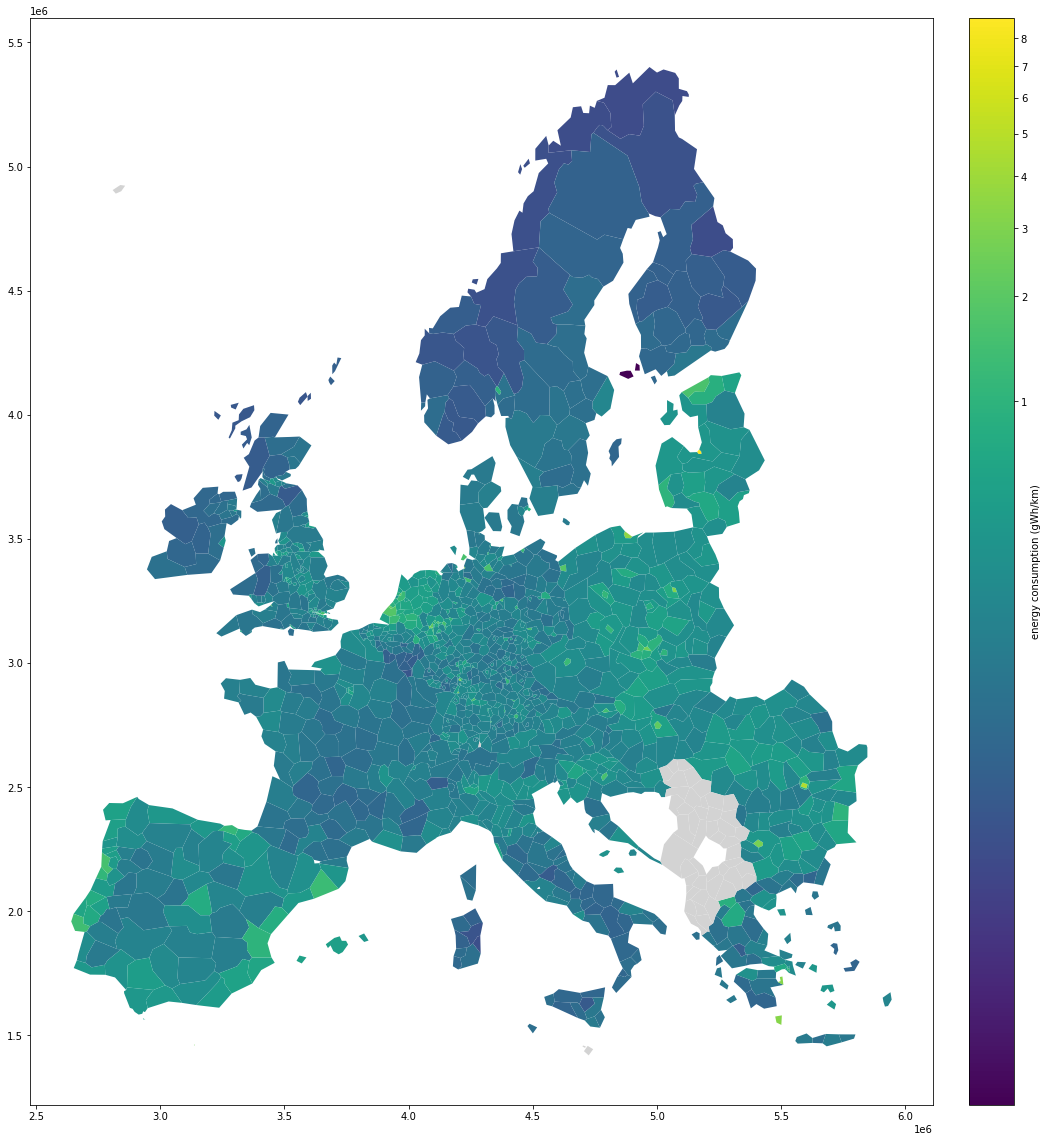

In [61]:
gdf_gWh_div_roadkm_perRegion = gdf_gWh_div_roadkm_perRegion.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_gWh_div_roadkm_perRegion.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

<AxesSubplot:>

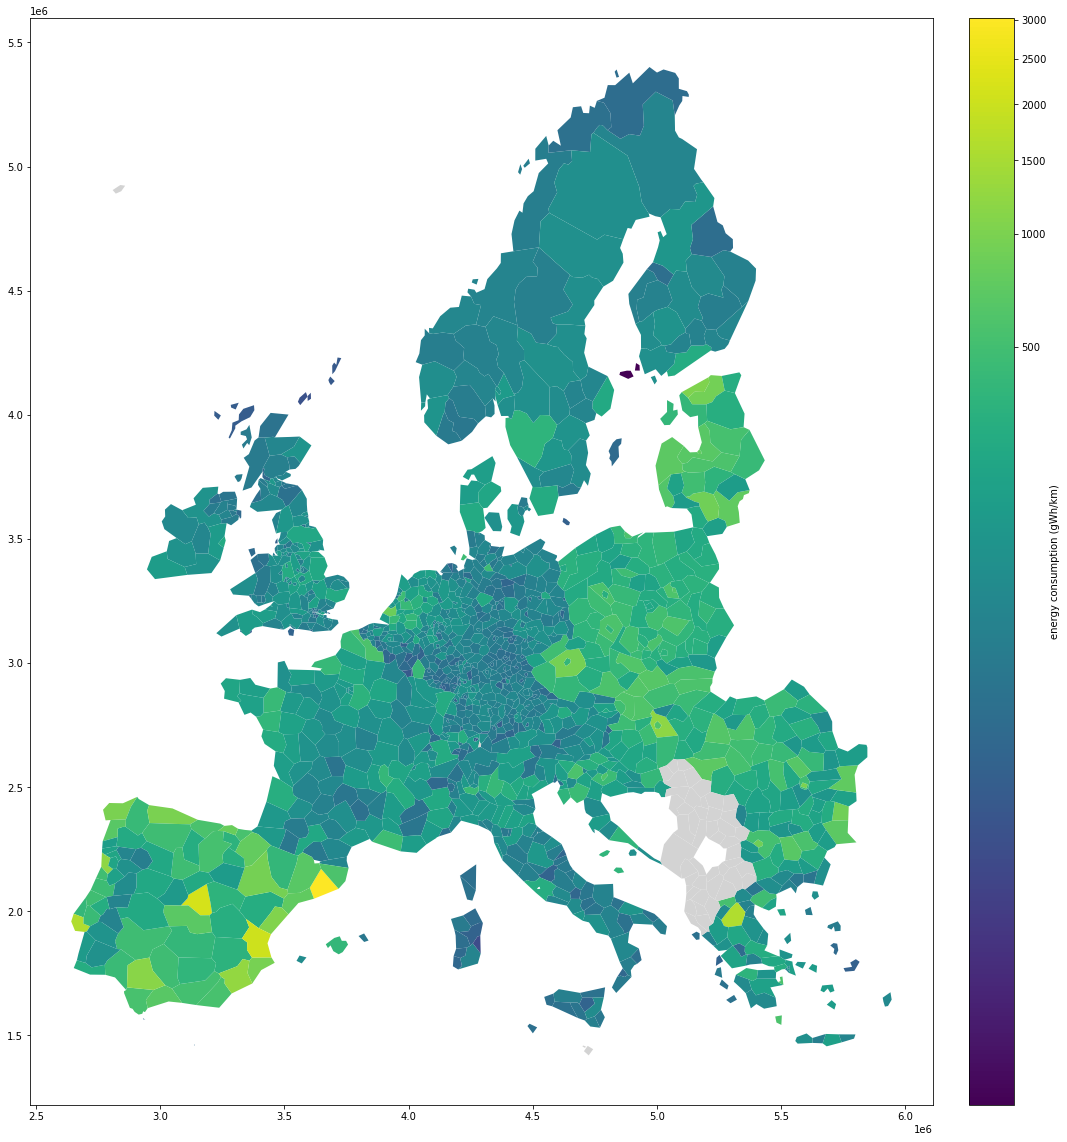

In [62]:
gdf_gWh_tot_region_tot = gdf_gWh_tot_region_tot.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_gWh_tot_region_tot.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

BEV_SynD_Bio

In [139]:
powertrain_share = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results.xlsm', sheet_name = 'BEV_SynD_Bio')
powertrain_share = powertrain_share.set_index(['Lifetime','distance_class','Powertrain'])
pow_share = powertrain_share.drop(index = 'Total', level = 2)
powertrain_share_10y = pow_share.loc['10y']
kWh_tot = kWh_all_powertrains.multiply(powertrain_share_10y)
gWh_tot = kWh_tot.multiply(0.000001)
gWh_Powertrain_BEV_SynD_Bio = gWh_tot.groupby('Powertrain').sum()
gWh_tot_region = gWh_tot.multiply(transport_share_region)
gWh_tot_region_tot = gWh_tot_region.groupby('id').sum()
gdf_gWh_tot_region_tot = gdf_dw.join(gWh_tot_region_tot)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot.columns = gdf_gWh_tot_region_tot.columns.astype(str)
gWh_div_roadkm_perRegion = gdf_gWh_tot_region_tot[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion = gdf_dw.join(gWh_div_roadkm_perRegion)

<AxesSubplot:>

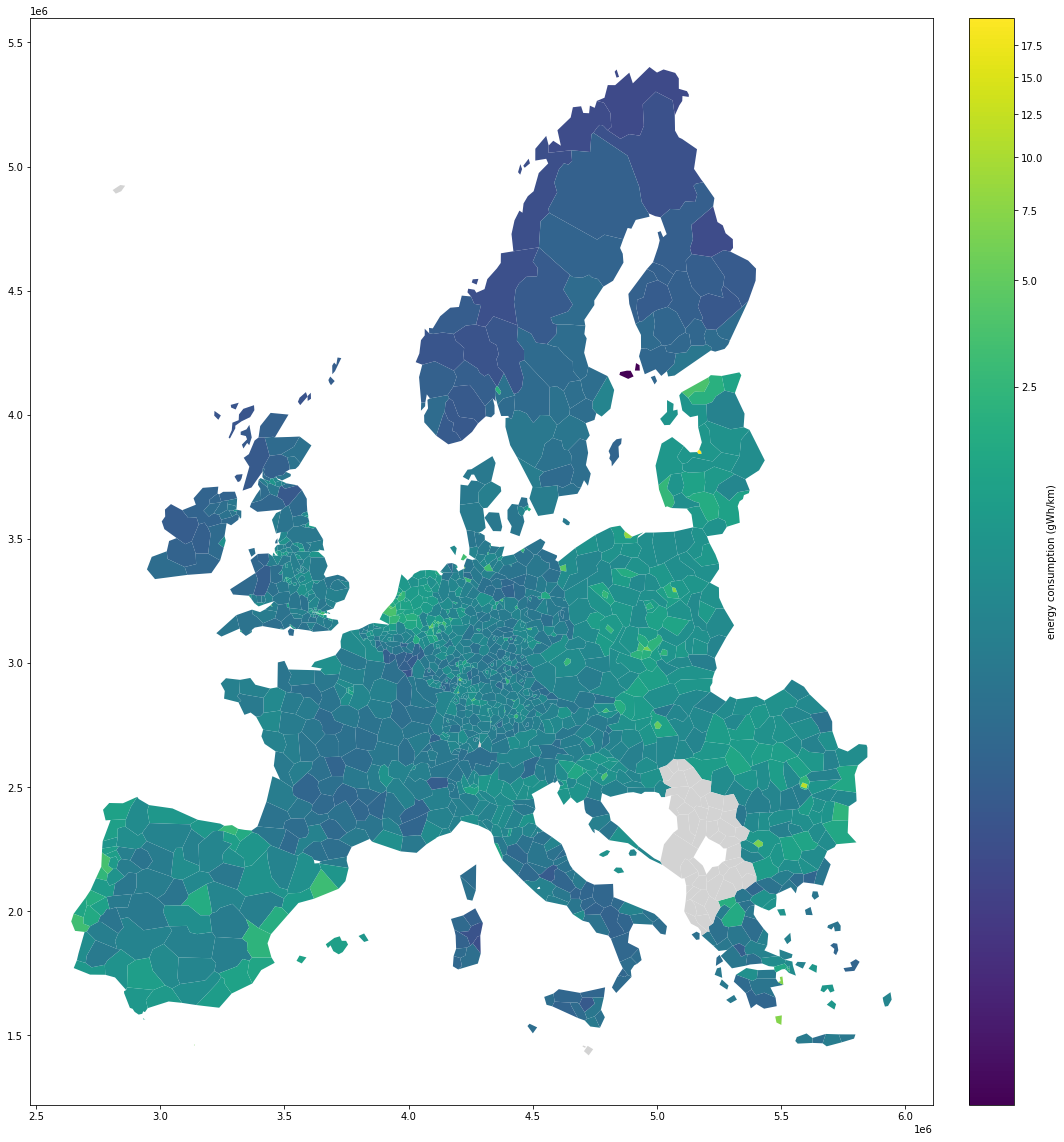

In [132]:
gdf_gWh_div_roadkm_perRegion = gdf_gWh_div_roadkm_perRegion.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_gWh_div_roadkm_perRegion.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

<AxesSubplot:>

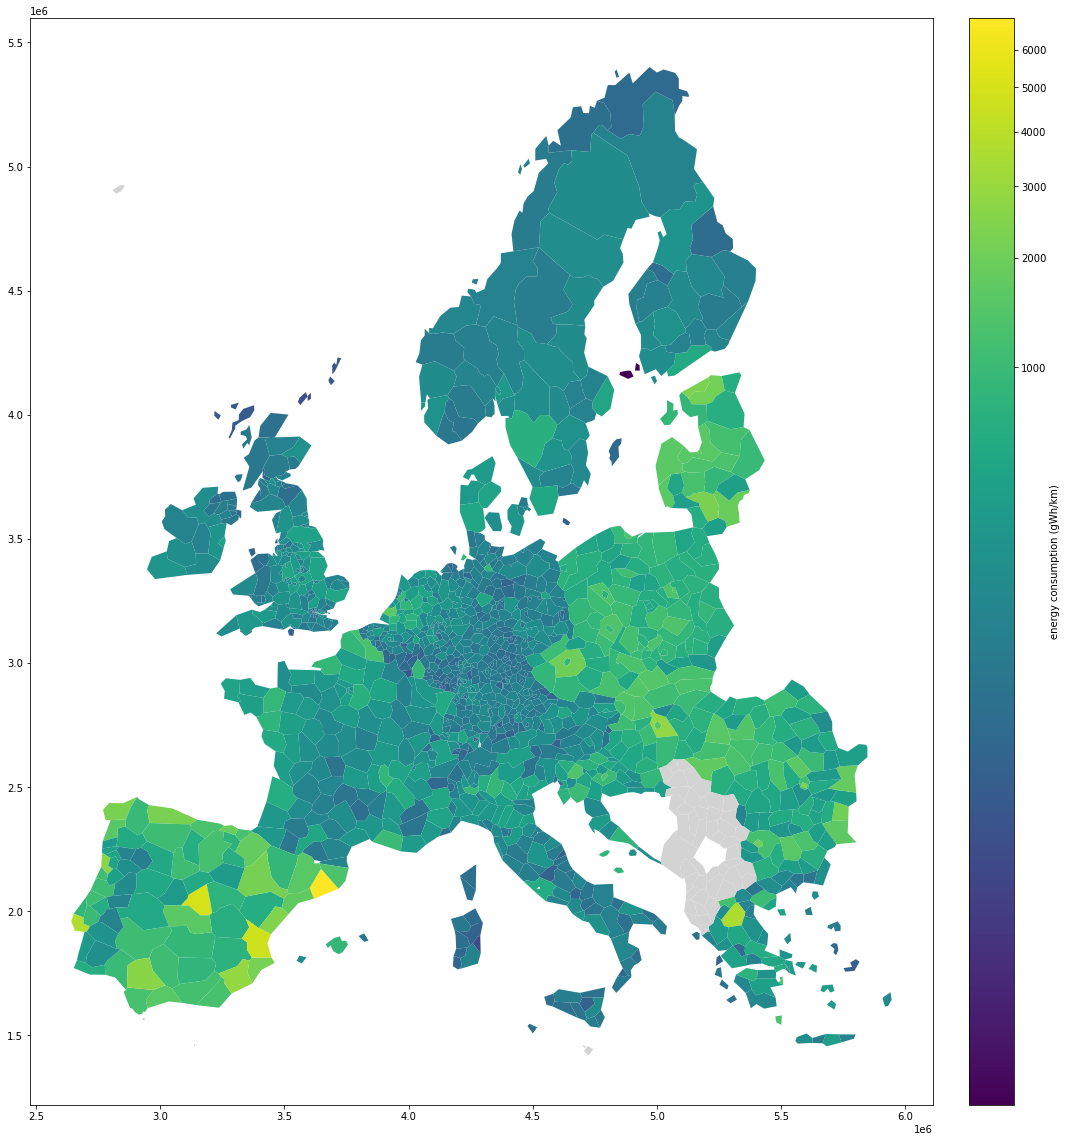

In [133]:
gdf_gWh_tot_region_tot = gdf_gWh_tot_region_tot.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_gWh_tot_region_tot.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

# Plots Summary of multiple Scenarios

In [134]:
#Plot total energy demand of vehicle fleet of each scenario
gWh_Powertrain_BEV_FCEV.columns = gWh_Powertrain_BEV_FCEV.columns.astype(str)
gWh_Powertrain_plot_BEV_FCEV = gWh_Powertrain_BEV_FCEV.loc[['BEV', 'Diesel ', 'Diesel HEV', 'FCEV'], ['2020', '2030', '2040', '2050']]
gWh_Powertrain_plot_BEV_FCEV.loc['BEV_FCEV',:]= gWh_Powertrain_plot_BEV_FCEV.sum(axis=0)
gWh_plot_BEV_CEV = gWh_Powertrain_plot_BEV_CEV.drop(['BEV', 'Diesel ', 'Diesel HEV', 'CEV'])
gWh_plot_BEV_CEV.index.names = ['Scenario']

gWh_Powertrain_BEV_CEV.columns = gWh_Powertrain_BEV_CEV.columns.astype(str)
gWh_Powertrain_plot_BEV_CEV = gWh_Powertrain_BEV_CEV.loc[['BEV', 'Diesel ', 'Diesel HEV', 'CEV'], ['2020', '2030', '2040', '2050']]
gWh_Powertrain_plot_BEV_CEV.loc['BEV_CEV',:]= gWh_Powertrain_plot_BEV_CEV.sum(axis=0)
gWh_plot_BEV_FCEV = gWh_Powertrain_plot_BEV_FCEV.drop(['BEV', 'Diesel ', 'Diesel HEV', 'FCEV'])
gWh_plot_BEV_FCEV.index.names = ['Scenario']

gWh_Powertrain_BEV_SynD_Bio.columns = gWh_Powertrain_BEV_SynD_Bio.columns.astype(str)
gWh_Powertrain_plot_BEV_SynD_Bio = gWh_Powertrain_BEV_SynD_Bio.loc[['BEV', 'Diesel ', 'Diesel HEV', 'CEV'], ['2020', '2030', '2040', '2050']]
gWh_Powertrain_plot_BEV_SynD_Bio.loc['BEV_CEV',:]= gWh_Powertrain_plot_BEV_SynD_Bio.sum(axis=0)
gWh_plot_BEV_SynD_Bio = gWh_Powertrain_plot_BEV_SynD_Bio.drop(['BEV', 'Diesel ', 'Diesel HEV', 'FCEV'])
gWh_plot_BEV_SynD_Bio.index.names = ['Scenario']
gWh_plot_BEV_SynD_Bio

KeyError: "['FCEV'] not found in axis"

In [141]:
gWh_Powertrain_BEV_SynD_Bio

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Powertrain,,,,,,,,,,,,,,,,,,,,,
BEV,24.483444,30.472344,38.555116,49.612749,64.959936,86.594524,117.613858,162.926668,230.502993,333.634877,...,46279.930212,52247.226414,57624.526678,61823.378927,64324.717606,65545.714456,66277.074599,66878.187235,67448.392540,68011.457828
Biofuel,1160.576178,1734.059322,2301.966347,2863.517635,3417.933568,3964.434527,4502.240897,5030.573058,5548.651393,6055.696285,...,1271.407933,642.437548,216.390377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Biofuel HEV,2021.471077,2993.078206,3935.996676,4848.274198,5727.958484,6573.097244,7381.738190,8151.929032,8881.717482,9569.151252,...,30515.784985,31481.479701,32244.237454,32797.324585,33134.007439,33470.690292,33807.373145,34144.055999,34480.738852,34817.421705
CEV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CNG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CNG HEV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DME,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Diesel,446453.065683,428114.771603,409842.220163,391647.499439,373540.637915,355529.522463,337620.034601,319816.619758,302123.670898,284548.411873,...,9096.324728,3927.673454,1028.594602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Diesel HEV,0.000000,12683.878191,24869.662202,36528.457818,47626.844294,58124.298259,67969.286712,77093.310603,85401.755990,92759.699595,...,65024.294102,44649.065206,26002.423732,11720.677643,3812.745586,1035.548535,264.396032,66.598813,16.773900,4.237824


In [143]:
gWh_Powertrain_BEV_SynD_Bio.columns = gWh_Powertrain_BEV_SynD_Bio.columns.astype(str)
gWh_Powertrain_plot_BEV_SynD_Bio = gWh_Powertrain_BEV_SynD_Bio.loc[['Diesel ', 'Biofuel', 'Diesel HEV', 'Biofuel HEV', 'Synthetic Diesel HEV', 'BEV'], ['2020', '2030', '2040', '2050']]
gWh_Powertrain_plot_BEV_SynD_Bio.loc['BEV_SynD_Bio',:]= gWh_Powertrain_plot_BEV_SynD_Bio.sum(axis=0)
gWh_plot_BEV_SynD_Bio = gWh_Powertrain_plot_BEV_SynD_Bio.drop(['Diesel ', 'Biofuel', 'Diesel HEV', 'Biofuel HEV', 'Synthetic Diesel HEV', 'BEV'])
gWh_plot_BEV_SynD_Bio.index.names = ['Scenario']
gWh_plot_BEV_SynD_Bio

,2020,2030,2040,2050
Scenario,,,,
BEV_SynD_Bio,450421.573986,390494.447679,407913.923799,462482.078799


In [144]:
gWh_Scenarios = pd.concat((gWh_plot_BEV_FCEV, gWh_plot_BEV_CEV, gWh_plot_BEV_SynD_Bio))
gWh_Scenarios

,2020,2030,2040,2050
Scenario,,,,
BEV_FCEV,450524.505764,388529.413757,320512.977797,324138.703897
BEV_CEV,450523.050588,388337.760782,257594.844433,208374.356151
BEV_SynD_Bio,450421.573986,390494.447679,407913.923799,462482.078799


<AxesSubplot:>

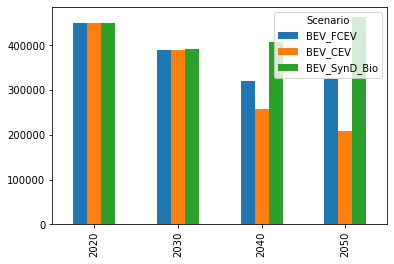

In [145]:
gWh_Scenarios.T.plot(kind = 'bar')

# Multiple Linear Regression For Transport Demand 

In [44]:
Vkm = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Vkm_1999-2019_P')
Vkm = Vkm.set_index('country')
GDP = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'GDP_1999-2019_P')
GDP = GDP.set_index('country')
GDPc = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'GDPc_1999-2019_P')
GDPc = GDPc.set_index('country')
Pop = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Pop_1999-2019_P')
Pop = Pop.set_index('country')
FuelPrice = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Fuel_Price_1999-2019_P')
FuelPrice = FuelPrice.set_index('country')
Size = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Country_Size_P')
Size = Size.set_index('country')

XLRDError: No sheet named <'Vkm_1999-2019_P'>

In [ ]:
GDP.columns = GDP.columns.astype(str)
Vkm.columns = Vkm.columns.astype(str)
print(GDP.columns)
print(Vkm.columns)

In [ ]:
Vkm.align(GDP)

In [ ]:
Vkm

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
FuelPrice.T.plot(ax=ax)

In [ ]:
x = GDP
y = Vkm

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

predictions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
predictions.T.plot(ax=ax)

# Test area

In [ ]:
toe_mio_Vkm_country.columns = ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016','2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
toe_mio_Vkm_country

In [ ]:
gdf_MWh_region = gdf_dw.join(MWh_region)
gdf_MWh_region = gdf_MWh_region.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200'])
fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_MWh_region.plot(column = '2019', 
         ax = ax, 
         legend=True,
         cax = cax,
         legend_kwds = {'label': 'energy consumption (mwh)'},
         cmap = 'viridis',
         missing_kwds= dict(color = "lightgrey")
         )

In [ ]:
maxValuesObj = MWh_region_filledna.max()
pd.set_option("display.max_rows", 50, "display.max_columns", 50)
MWh_region_filledna.loc[(slice(None), 'FR'), :]

gdf_MWh_region_select = gdf_MWh_region.cx[0.22:,1:]

In [ ]:
toe_mio_Vkm_country.columns = toe_mio_Vkm_country.columns.int.replace(' ', '')
print(toe_mio_Vkm_country.columns)

In [ ]:
MWh_region.columns = MWh_region.columns.str.replace(' ', '')
print(MWh_region.columns)

In [ ]:
MWh_region.columns = ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016','2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
MWh_region

In [ ]:
#loading international transport dataset
df_unloading_int_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ia_ugtt.tsv.gz',['Type_of_carriage', 'Region', 'subsector', 'unit', 'country'])
df_loading_int_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ia_lgtt.tsv.gz',['Type_of_carriage', 'Region', 'subsector', 'unit', 'country'])
#filtering dataset to proper data
df_unloading_int_EC = df_unloading_int_EC.loc[('TOT', 'WORLD', 'TOTAL')]
df_unloading_int_EC = df_unloading_int_EC.droplevel(0)
df_loading_int_EC = df_loading_int_EC.loc[('TOT', 'WORLD', 'TOTAL')]
df_loading_int_EC = df_loading_int_EC.droplevel(0)
#average of loaning and unloading
df_average_transport_total_int_EC = pd.concat((df_loading_int_EC, df_unloading_int_EC))
df_average_transport_total_int_EC = df_average_transport_total_int_EC.groupby(df_average_transport_total_int_EC.index).mean()
#multiplay international transport with share of total national tranport for each region
international_transport_region = share_total_national_transport_region.multiply(df_average_transport_total_int_EC)
#sum of national and international transport
df_average_transport_total = df_average_transport_total.droplevel(1)
international_transport_region = international_transport_region.droplevel(1)
total_national_international_transport_region = pd.concat((international_transport_region, df_average_transport_total))
total_national_international_transport_region = total_national_international_transport_region.groupby('id').sum()
total_national_international_transport_region

In [ ]:
international_transport_region

In [ ]:
df_average_transport_total

In [ ]:
#devide total mio vehicle TKM by total transport per region to get km driven by trucks in that region
df_total_transport_mio_Tkm_region_EC = share_total_national_transport_region.multiply(df_total_transport_mio_Tkm_country_EC)
km_driven_region = df_total_transport_mio_Tkm_region_EC.divide(total_national_international_transport_region)
km_driven_region

In [ ]:
df_total_transport_mio_Tkm_region_EC

In [ ]:
df_total_transport_mio_Tkm_region_EC = share_total_national_transport_region.multiply(df_total_transport_mio_Tkm_country_EC)

In [ ]:
test = km_driven_region.iloc[1343:1522]

In [ ]:
print(gdf.iloc[0:5])

In [ ]:
#trying to use different dataset with total transport amount
df_unloading_test = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_ru.tsv.gz',['subsector', 'unit', 'region'])

In [ ]:
idx = pd.IndexSlice
df_unloading_test = df_unloading_test.loc[idx[:,'THS_T'], :]
df_unloading_test = df_unloading_test.droplevel('unit')
df_unloading_test

In [ ]:
df_unloading_test = df_unloading_test.reindex(gdf.set_index('id').index)




df_unloading_test = df_unloading_test.loc[idx[:,['THS_T']]]
df_unloading_test = df_unloading_test.droplevel(1)
df_unloading_total = df_unloading.loc['THS_T']
df_unloading_test

In [ ]:
df_unloading_test = df_unloading_test.droplevel(0)

In [ ]:
#sorting gdf according to id so it might aligne with eurostats data
gdf_sort = gdf.sort_values(by=['id'])

In [ ]:
#selecting 2019 column
df_at_2019 = df_average_transport.iloc[:, 0]

In [ ]:
print(df_at_2019.iloc[100:105])

In [ ]:
gdf_sort['TRANSPORT_AMOUNT_2019'] = df_at_2019

In [ ]:
print(gdf_sort.iloc[100:150])

In [ ]:
gdf_sort.head()

In [ ]:
#alinge dataframes and delet all lines with no shared id